# SSP-MMC for FSRS

SSP-MMC stands for "Stochastic-Shortest-Path-Minimize-Memorization-Cost". It is a reinforcement learning algorithm that is designed to minimize the cost of memorization in the context of spaced repetition. This is a re-implementation of the original SSP-MMC algorithm in Numpy. The memory model is updated to FSRS instead of DHP-HLR.

Original code: https://github.com/maimemo/SSP-MMC

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

plt.style.use('ggplot')

from fsrs import FsrsSimulator

w = [
    0.5701, 1.4436, 4.1386, 10.9355,
    5.1443, 1.2006, 0.8627, 0.0362,
    1.629, 0.1342, 1.0166,
    2.1174, 0.0839, 0.3204, 1.4676,
    0.219, 2.8237
]

/var/folders/3h/t42_2k2d0tqf3gl1_tjslcbr0000gn/T/ipykernel_89169/1648295319.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [19]:
sim_org = FsrsSimulator(w, config_path='config_equispaced_r.yaml')

(31, 914, 11) (31, 914, 11) (31, 914, 11) (31, 914, 11)


{'bodies': [<matplotlib.collections.PolyCollection at 0x11fe60e90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11fe85d50>,
 'cmins': <matplotlib.collections.LineCollection at 0x11fe95b10>,
 'cbars': <matplotlib.collections.LineCollection at 0x11fe97010>}

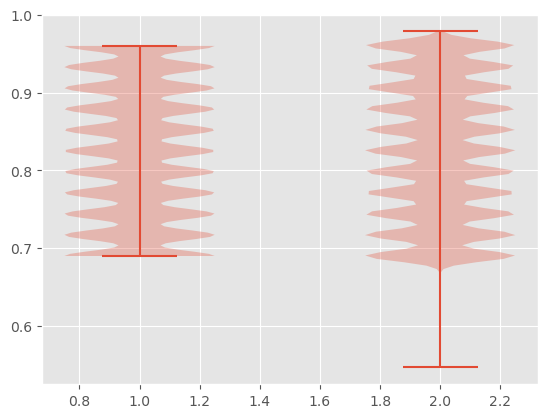

In [20]:
# visualize retrievability dist for option 1: constructing for equally spaced R
plt.violinplot([sim_org.r_state_mesh_org.flatten(), sim_org.r_state_mesh.flatten()], [1,2])

In [22]:
sim = FsrsSimulator(w, config_path='config_equispaced_ivl.yaml')

(31, 914, 365) (31, 914, 365) (31, 914, 365) (31, 914, 365)


{'bodies': [<matplotlib.collections.PolyCollection at 0x11fed6e50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x11fe6e350>,
 'cmins': <matplotlib.collections.LineCollection at 0x11ff06dd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11ff07e50>}

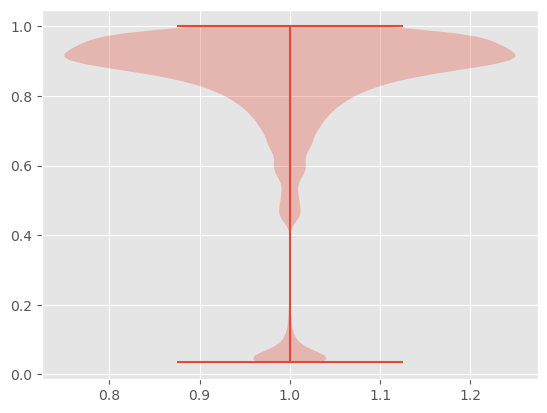

In [23]:
# visualize retrievability dist for option 2: equally spaced ivls
plt.violinplot(sim.r_state_mesh[:, ::51].flatten())

In [21]:
sim.run(max_iter=2)

iteration     0, diff 16754400.88, time 1.06s
Time: 2.19s


In [22]:
avg_cost = sim.get_avg_cost()
print(f"Average cost: {avg_cost:.2f}")

retention_matrix = sim.get_retention_matrix()
avg_retention = retention_matrix.mean()
print(f"Average retention: {avg_retention:.2f}")

Average cost: 168.28
Average retention: 0.92


## Visualization of the optimal policy

(31, 914)

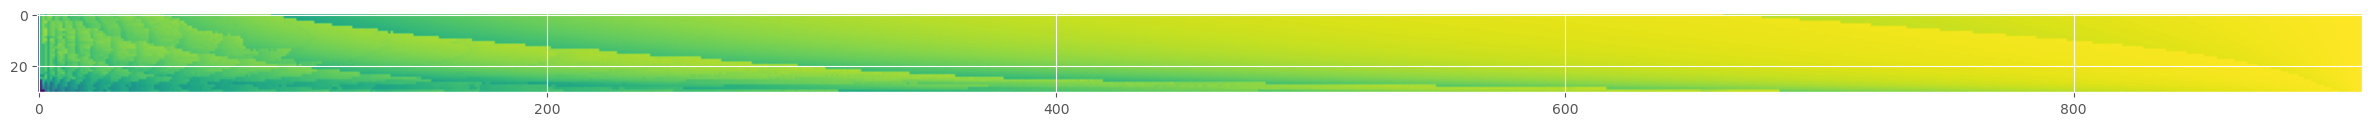

In [25]:
plt.figure(figsize=(30, 8))
plt.imshow(retention_matrix)
retention_matrix.shape

(31, 914)

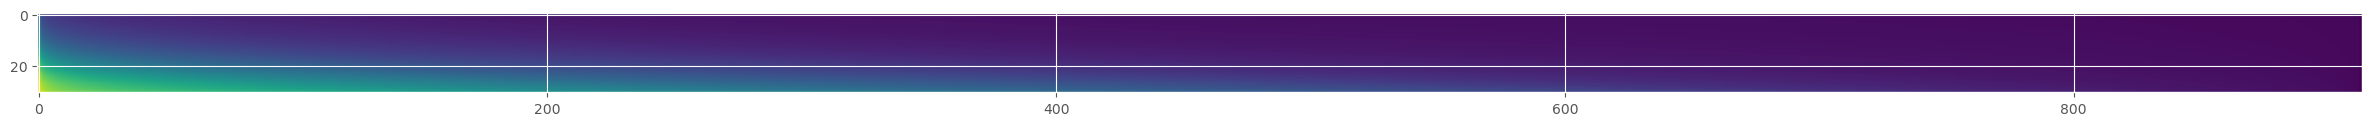

In [26]:
plt.figure(figsize=(30, 8))
plt.imshow(sim.cost_matrix)
sim.cost_matrix.shape

## Retrievability -> Lifetime cost

''

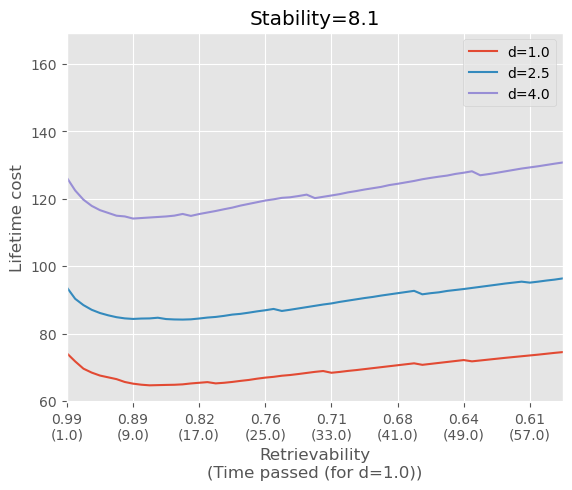

In [27]:
i_stability = 20
which_difficulty = 0

chosen_cost_matrix = sim.cost_matrix_per_ivl[:, i_stability, :] # choose a fixed time interval after which we review
# chosen_cost_matrix = cost_matrix # this corresponds to chooing the best next review time right now.

d_indices = [0,10,20,-1]
# d_indices = [5]
d_indices = [0,5,10]
d_labels = sim.d_state[d_indices].round(1)
d_labels = [f'd={d:.1f}' for d in d_labels]

lifetime_cost = sim.cost_matrix_per_ivl[d_indices, i_stability, :].T
plt.plot(lifetime_cost, label=d_labels)
plt.legend()
plt.ylabel('Lifetime cost')
plt.title(f'Stability={sim.s_state[i_stability]:.1f}')
plt.xlabel('Retrievability')

retrievability = sim.r_state_mesh[d_indices[which_difficulty], i_stability].round(2)
ts = np.arange(len(retrievability))
if False: # print retrievability
    ts, retrievability = ts[::10], retrievability[::10]
    plt.xticks(ts, retrievability)
else: # print retrievability & time passed
    passed_time = sim.ivl_mesh[d_indices[which_difficulty], i_stability]
    ls = [f'{r:.2f}\n({(t)})' for t, r in zip(passed_time, retrievability)]
    ts, ls = ts[::8], ls[::8]
    plt.xticks(ts, ls)
    plt.xlabel(f'Retrievability\n(Time passed (for {d_labels[which_difficulty]}))')

plt.xlim(0,60)
;

## Time passed -> Lifetime cost

In [28]:
def difference_in_lifetime_cost_at_passed_times(lifetime_cost, passed_time, at, filter=[1]):
    assert lifetime_cost.ndim == 1
    assert lifetime_cost.shape == passed_time.shape
    assert np.isclose(sum(filter), 1), f'filter {filter} should sum to 1 but sums to {sum(filter)}'
    
    # copy to avoid modifying the original
    lifetime_cost, passed_time, at, filter = lifetime_cost.copy(), passed_time.copy(), at.copy(), filter.copy()
    
    diff = np.diff(passed_time)
    assert diff.any(), 'a time series with no time difference is not valid (and our flipping logic would not work).'
    if not (diff <= 0).all():
        # flip:
        passed_time = passed_time[::-1]
        filter = filter[::-1]
        lifetime_cost = lifetime_cost[::-1]
        
    assert (np.diff(passed_time) <= 0).all(), 'expect passed_time in non-increasing or non-decreasing order'
    assert (np.diff(filter) >= 0).all(), f'the filter should prefer values in the close future over the distant future (notice that we flipped based on passed_time).\n{filter} is not in increasing order. diff: {np.diff(filter)}'
    
    difference = []
    for time_passed in at:
        i_first_smaller = len(passed_time)-1
        for i, t in enumerate(passed_time):
            if i>0 and t < time_passed:
                i_first_smaller = i
                break
            
        # prev and future here indicate not the position in the array but the associated time - which goes backwards in the array.
        # thus future is before the past in the array
            
        past_score = lifetime_cost[i_first_smaller] # sum(filter_weight * lifetime_cost[filter_index] for filter_index, filter_weight in zip(filter_indices, filter))
        
        filter_indices = i_first_smaller + np.arange(-len(filter), 0)
        filter_indices = np.clip(filter_indices, 0, len(lifetime_cost)-1)
        future_score = sum(filter_weight * lifetime_cost[filter_index] for filter_index, filter_weight in zip(filter_indices, filter)) # lifetime_cost[i_first_smaller-1] 
        
        difference.append(future_score-past_score)
        
        # print(filter_indices, lifetime_cost[filter_indices], filter)
    return difference

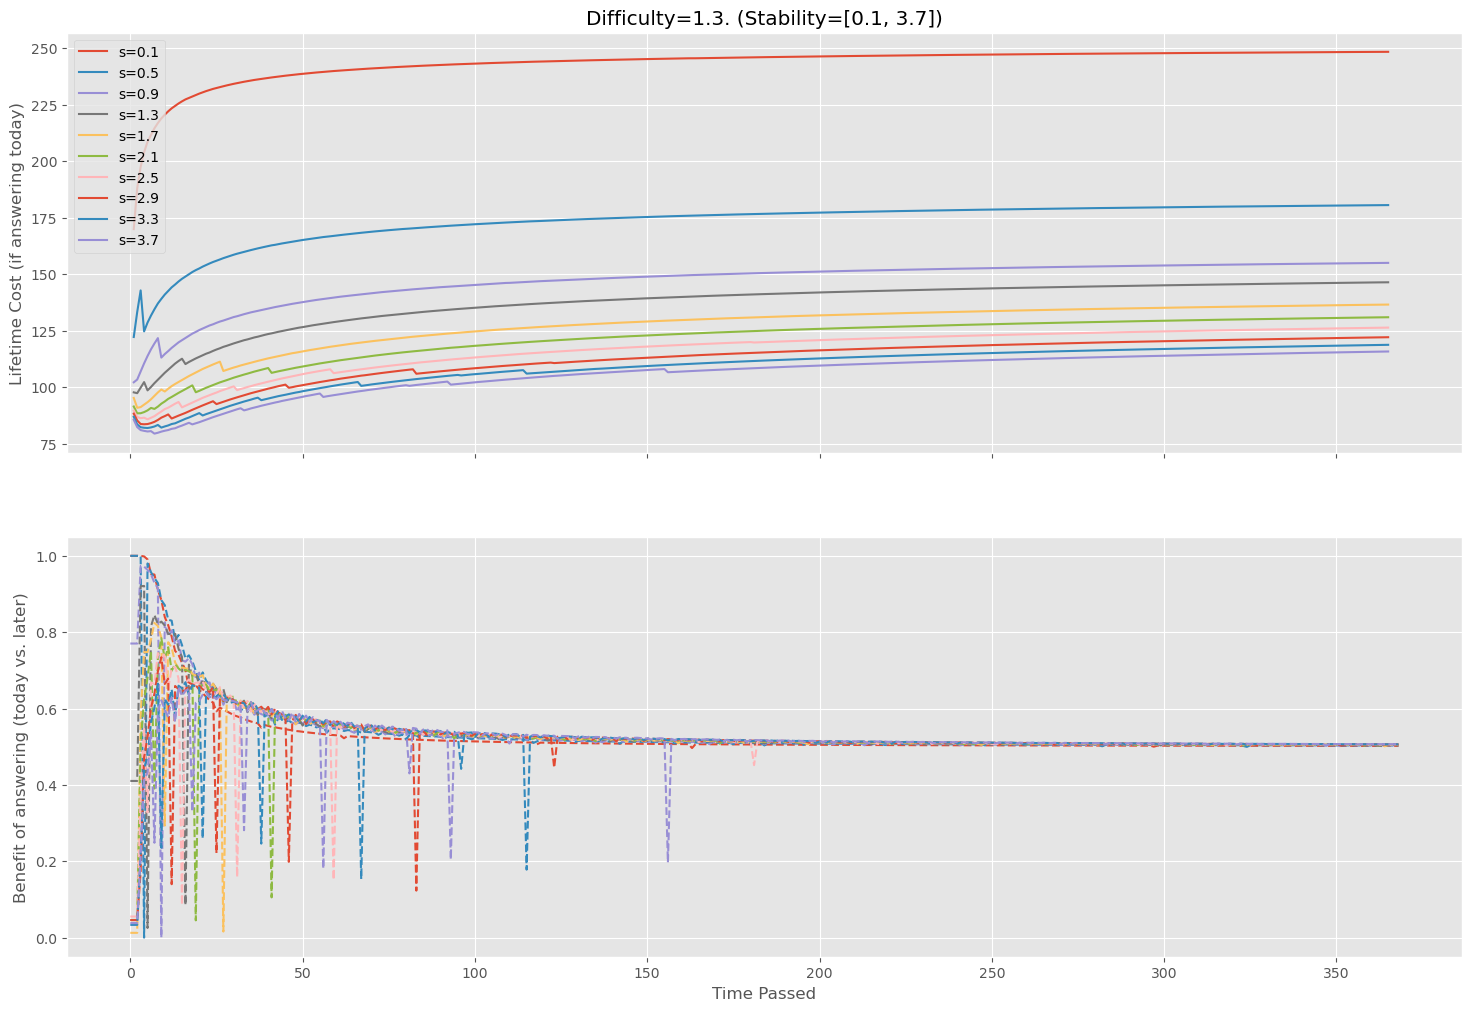

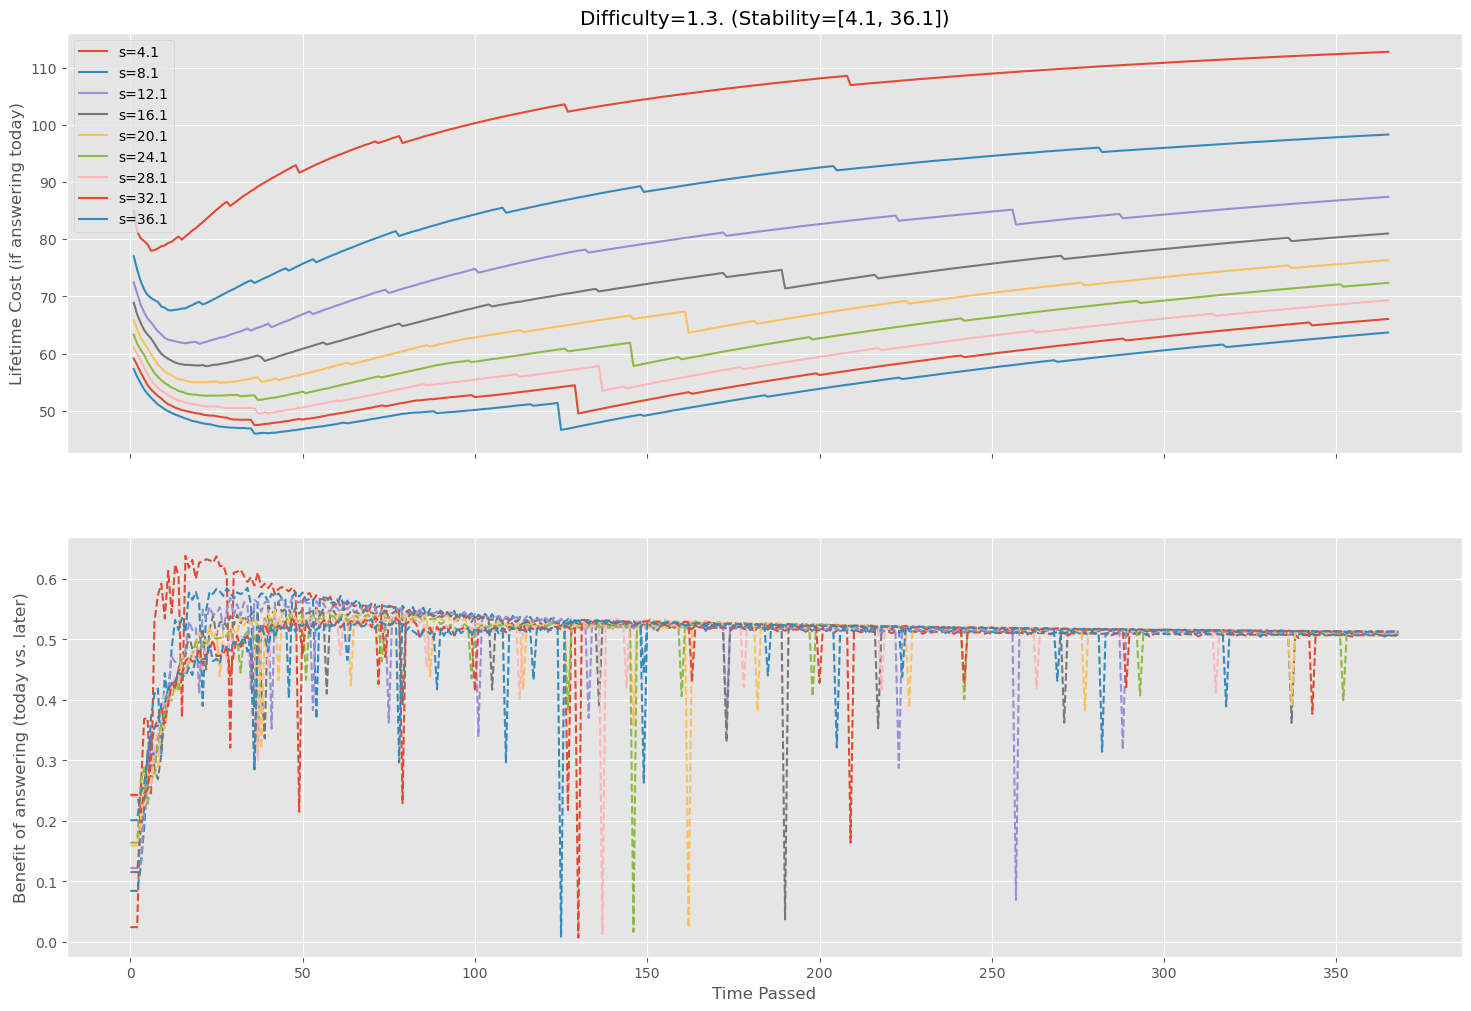

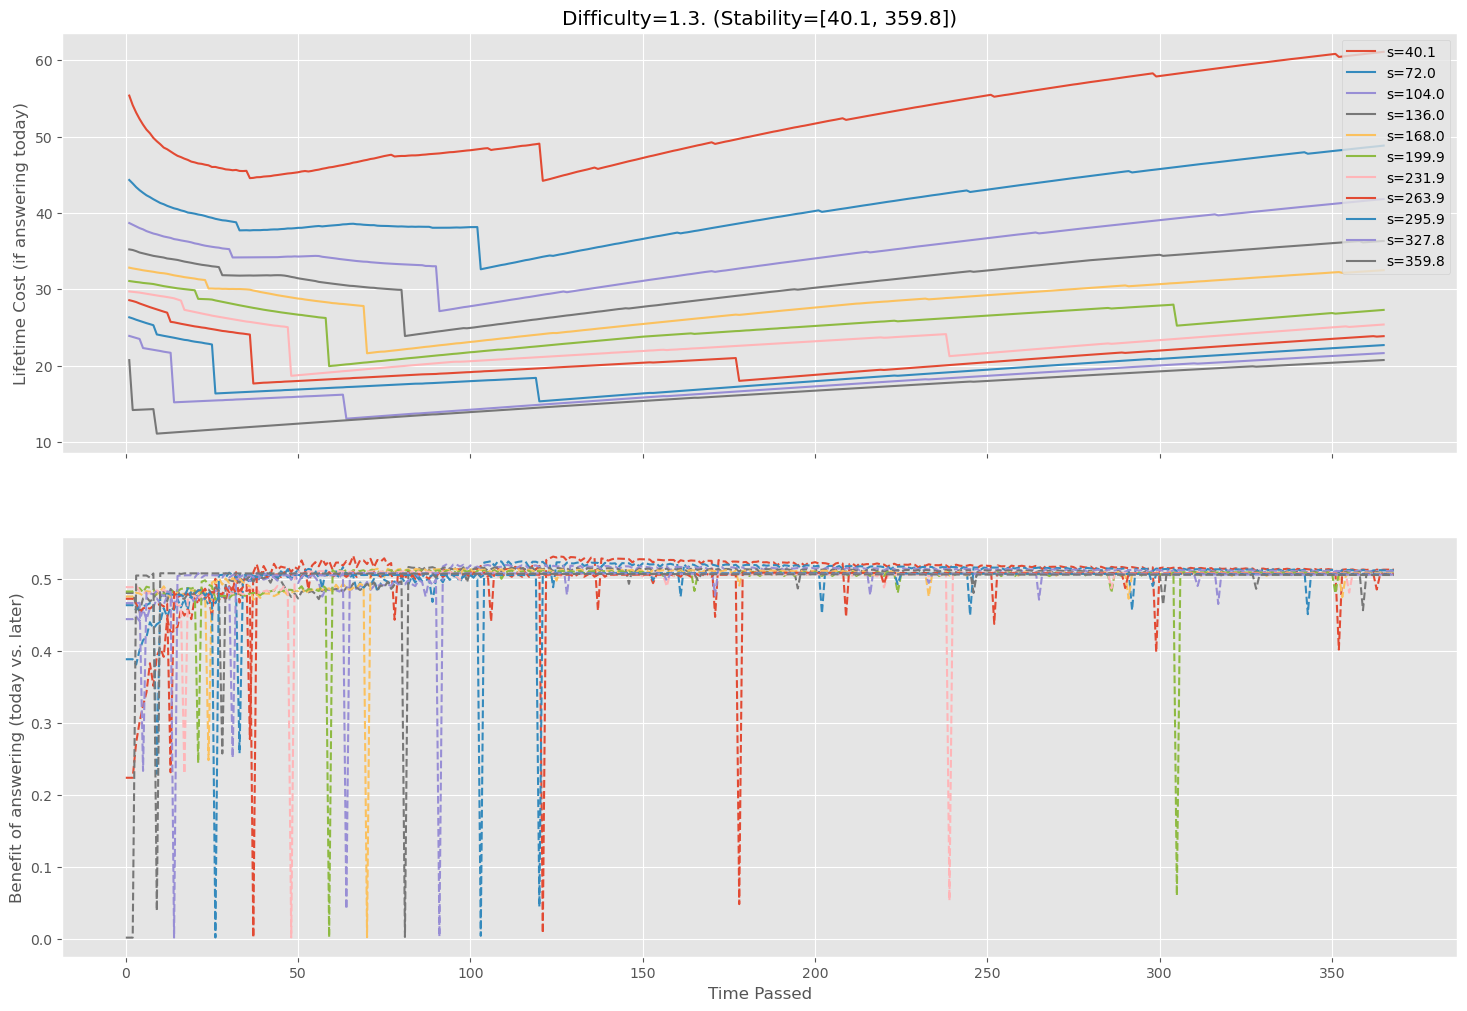

In [29]:
smoothing_sigma = 0

plot_differences = True
differences_filter = [1]
# differences_filter = [.6, .3, .1]


iss = [range(0,10,1), range(10,100,10), range(100, len(sim.s_state), 80)]
# iss = [range(10,100,30)]
# iss = [[5]]
i_difficulty = 1

for is_stability in iss:
    lifetime_cost = sim.cost_matrix_per_ivl[i_difficulty, is_stability, :].T
    lifetime_cost = gaussian_filter(lifetime_cost, sigma=smoothing_sigma, axes=0)
    passed_time = sim.ivl_mesh[i_difficulty, is_stability].T
    stability = sim.s_state[is_stability].round(1)
    
    # mask out those 'time series' that all have the same time
    mask = ~(passed_time == passed_time[:1, :]).all(axis=0)
    passed_time = passed_time[:, mask]
    lifetime_cost = lifetime_cost[:, mask]
    stability = stability[mask]
    
    labels = [f's={s:.1f}' for s in stability]
    
    passed_time[-1] += .001
    
    if not plot_differences:
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
        
        passed_time_dense = list(range(np.floor(np.min(passed_time)).astype(int), np.floor(np.max(passed_time)).astype(int) + 4))
        passed_time_dense = list(range(0, np.floor(np.max(passed_time)).astype(int) + 4))
        difference = np.zeros((len(passed_time_dense), lifetime_cost.shape[1]))
        
        for i in range(lifetime_cost.shape[1]):
            difference[:, i] = difference_in_lifetime_cost_at_passed_times(lifetime_cost[:, i], passed_time[:, i], at=passed_time_dense, filter=differences_filter)
            
        # difference = difference >= 0
            
        # sigmoid
        difference = 1 / (1 + np.exp(-difference))
            
        # Plot on the second subplot with shared x-axis
        ax2.plot(passed_time_dense, difference, linestyle='--', label=labels)
        ax2.set_ylabel('Benefit of answering (today vs. later)')
        ax2.set_xlabel('Time Passed')

    # Plot on the first subplot
    ax1.plot(passed_time, lifetime_cost, label=labels)
    ax1.set_ylabel('Lifetime Cost (if answering today)')
    ax1.legend()
    ax1.set_title(f'Difficulty={sim.d_state[i_difficulty]:.1f}. (Stability=[{stability.min()}, {stability.max()}])')

    plt.show()

''

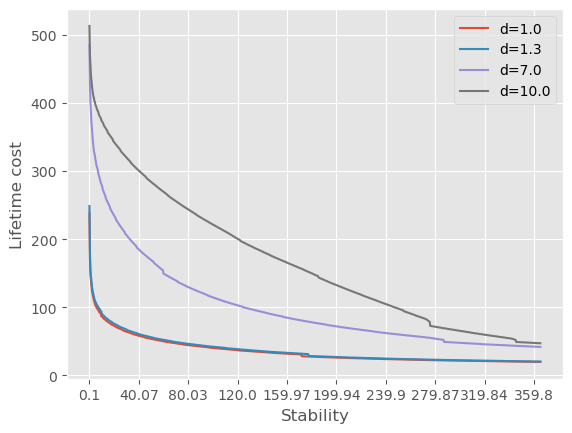

In [30]:
chosen_cost_matrix = sim.cost_matrix # this corresponds to chooing the best next review time right now.
chosen_cost_matrix = sim.cost_matrix_per_ivl[:,:,-10] # choose a fixed time interval after which we review

d_indices = [0,1,20,-1]
d_labels = sim.d_state[d_indices].round(1)
d_labels = [f'd={d:.1f}' for d in d_labels]
data = chosen_cost_matrix.T[:, d_indices]

plt.plot(data, label=d_labels)
plt.legend()
plt.ylabel('Lifetime cost')
plt.xlabel('Stability')
ts = range(len(sim.s_state))
ls = sim.s_state.round(2)
ts, ls = ts[::100], ls[::100]
plt.xticks(ts, ls)
;

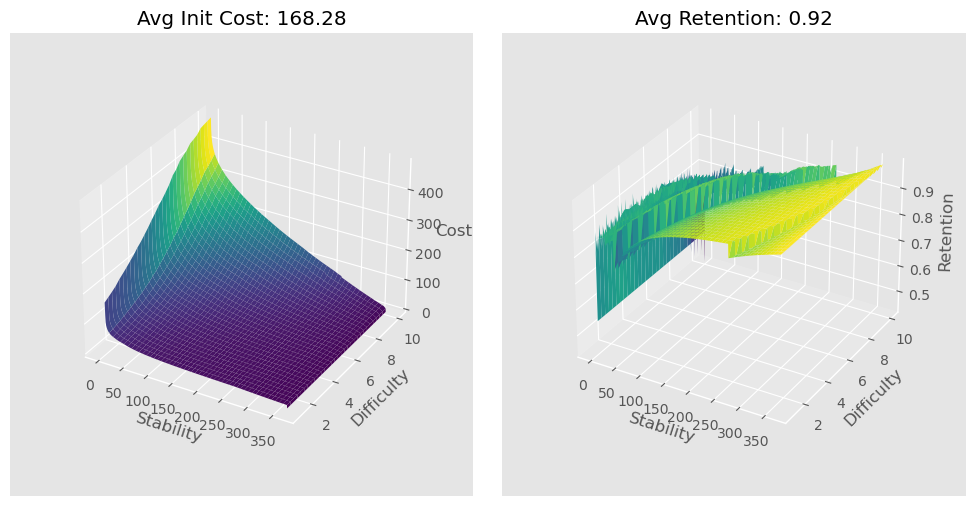

In [31]:
s_state_mesh_2d, d_state_mesh_2d = np.meshgrid(sim.s_state, sim.d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, sim.cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_title(f"Avg Init Cost: {avg_cost:.2f}")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, retention_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_title(f"Avg Retention: {avg_retention:.2f}")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()

## This was last run with the old ivl's, don't rerun it or you loose the 5min computation:

Retention: 69.00%
Time: 1.01s, Iterations: 345


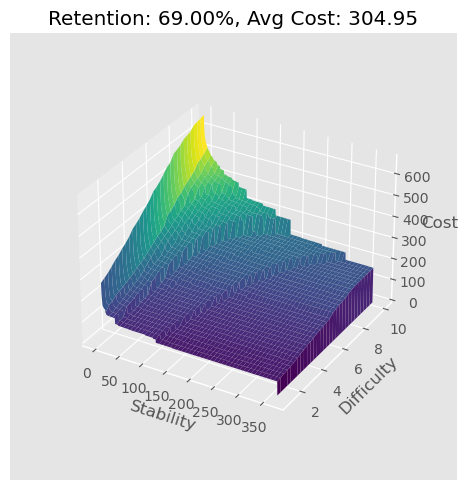

Retention: 72.00%
Time: 0.96s, Iterations: 335


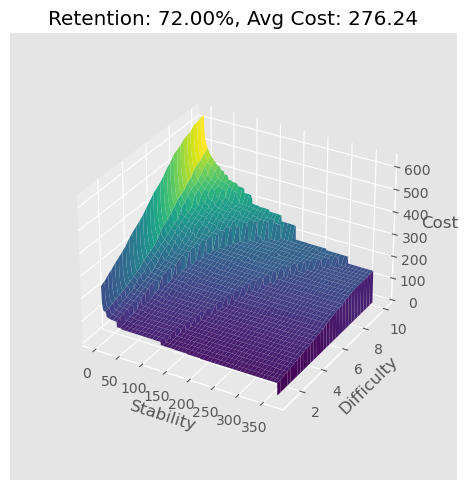

Retention: 75.00%
Time: 0.95s, Iterations: 328


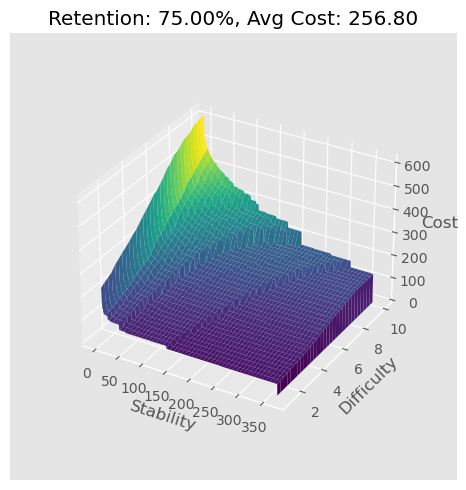

Retention: 78.00%
Time: 0.93s, Iterations: 333


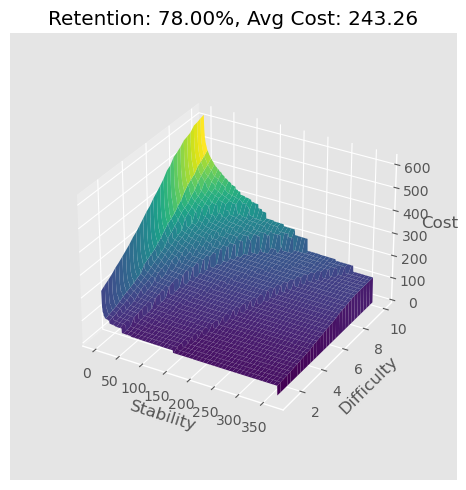

Retention: 81.00%
Time: 0.82s, Iterations: 329


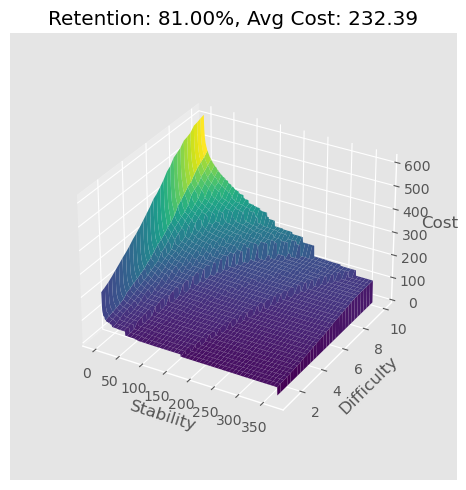

Retention: 84.00%
Time: 0.86s, Iterations: 340


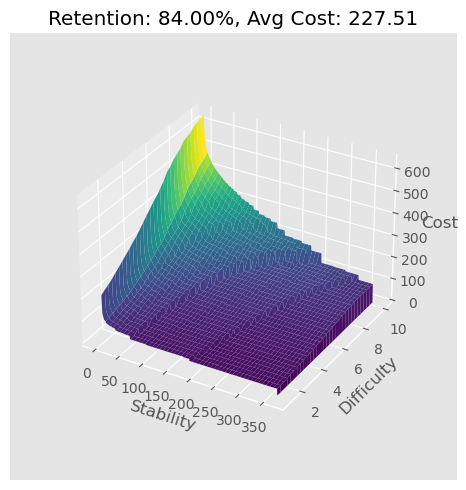

Retention: 87.00%
Time: 0.95s, Iterations: 354


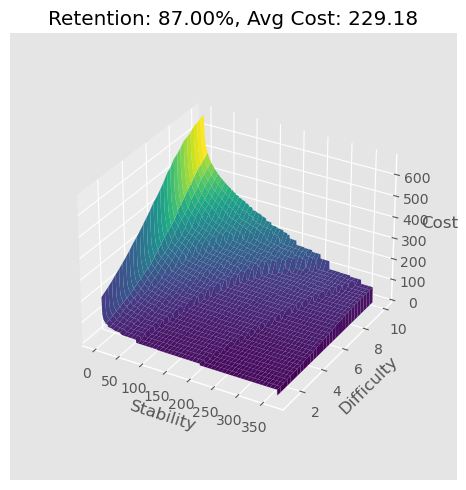

Retention: 90.00%
Time: 1.01s, Iterations: 383


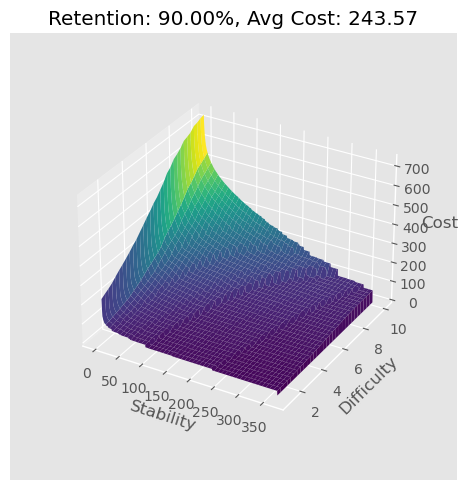

Retention: 93.00%
Time: 1.21s, Iterations: 427


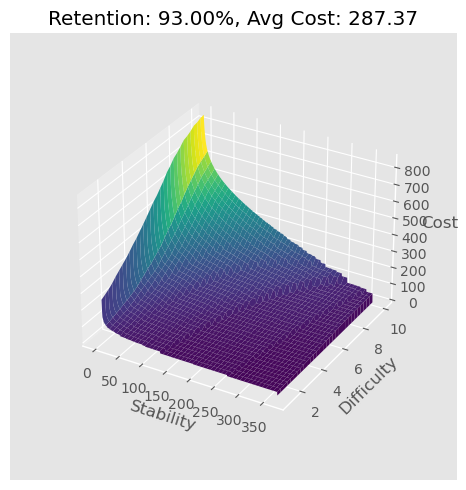

Retention: 96.00%
Time: 0.81s, Iterations: 290


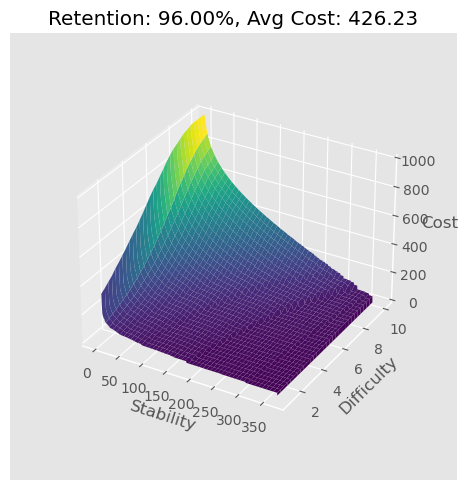

In [207]:
costs = []

r_range = np.linspace(r_min, r_max, 10)

for r in r_range:
    start = time.time()
    print(f"Retention: {r * 100:.2f}%")
    cost_matrix = np.zeros((d_size, s_size))
    cost_matrix.fill(1000)
    cost_matrix[:, -1] = 0
    s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
    r_state_mesh = r * np.ones((d_size, s_size))
    ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
    r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

    i = 0
    diff = 10000
    n_iter = 1000
    while i < n_iter and diff > 1e-4 * s_size * d_size:
        next_stability_after_again = stability_after_failure(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_again = next_difficulty(d_state_mesh, 1)
        next_cost_after_again = (
            i2c(next_stability_after_again,
                next_difficulty_after_again) + again_cost
        )

        next_stability_after_hard = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 2
        )
        next_difficulty_after_hard = next_difficulty(d_state_mesh, 2)
        next_cost_after_hard = (
            i2c(next_stability_after_hard, next_difficulty_after_hard) + hard_cost
        )

        next_stability_after_good = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 3
        )
        next_difficulty_after_good = next_difficulty(d_state_mesh, 3)
        next_cost_after_good = (
            i2c(next_stability_after_good, next_difficulty_after_good) + good_cost
        )

        next_stability_after_easy = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 4
        )
        next_difficulty_after_easy = next_difficulty(d_state_mesh, 4)
        next_cost_after_easy = (
            i2c(next_stability_after_easy, next_difficulty_after_easy) + easy_cost
        )

        expected_cost = (
            r_state_mesh
            * (
                review_rating_prob[0] * next_cost_after_hard
                + review_rating_prob[1] * next_cost_after_good
                + review_rating_prob[2] * next_cost_after_easy
            )
            + (1 - r_state_mesh) * next_cost_after_again
        )
        # update cost matrix
        optimal_cost = np.minimum(cost_matrix, expected_cost)
        diff = cost_matrix.sum() - optimal_cost.sum()
        cost_matrix = optimal_cost
        i += 1
    end = time.time()
    print(f"Time: {end - start:.2f}s, Iterations: {i}")
    init_stability = np.array(w[0:4])
    init_difficulty = np.array([w[4] - (3 - g) * w[5] for g in range(1, 5)])
    init_cost = cost_matrix[d2i(init_difficulty), s2i(init_stability)]
    avg_cost = init_cost @ first_rating_prob
    costs.append(avg_cost)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
    ax.set_xlabel("Stability")
    ax.set_ylabel("Difficulty")
    ax.set_zlabel("Cost")
    ax.set_title(f"Retention: {r * 100:.2f}%, Avg Cost: {avg_cost:.2f}")
    ax.set_box_aspect(None, zoom=0.8)
    plt.tight_layout()
    plt.show()

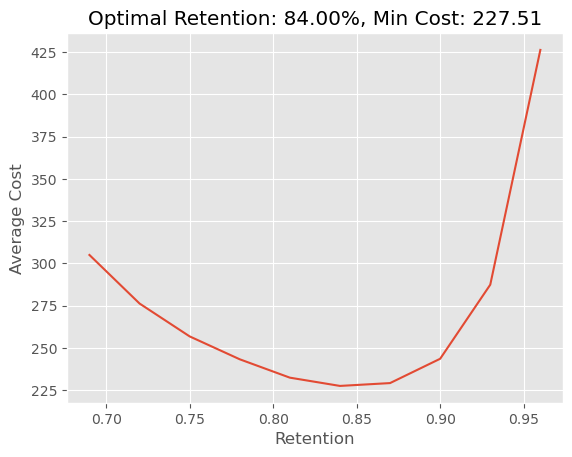

In [208]:
optimal_retention = r_range[np.argmin(costs)]
min_cost = np.min(costs)
plt.plot(r_range, costs)
plt.xlabel("Retention")
plt.ylabel("Average Cost")
plt.title(
    f"Optimal Retention: {optimal_retention * 100:.2f}%, Min Cost: {min_cost:.2f}"
)
plt.show()